In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using Revise
using LinearAlgebra
using Distributions
using Random
using StatsPlots
using PDMats
using StatsBase
using Base.Iterators
using DataFrames, TimeSeries, XLSX
using PrettyTables

In [3]:
includet("../VARs/utils.jl")
includet("../VARs/VAR_OLS.jl")

In [18]:
df = DataFrame(XLSX.readtable("../../data/Macro_data_poland.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :observation_date), Dates.year, first)

start = Date(2001, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data_source, start),end_d)

24×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2001-01-01 to 2024-01-01
┌────────────┬───────────────┬─────────────────┬─────────────────┬──────────────
│            │ NGDPRSAXDCPLQ │ IRLTLT01PLQ156N │ IR3TIB01PLQ156N │ NGDPDSAIXPL ⋯
├────────────┼───────────────┼─────────────────┼─────────────────┼──────────────
│ 2001-01-01 │     2.51454e5 │         10.4267 │         18.1733 │       76.89 ⋯
│ 2002-01-01 │     2.53341e5 │         8.30667 │            10.4 │      80.017 ⋯
│ 2003-01-01 │     2.59851e5 │         5.61333 │            6.24 │      79.629 ⋯
│ 2004-01-01 │     2.76062e5 │         6.71333 │         5.48333 │      82.192 ⋯
│ 2005-01-01 │     2.82491e5 │            5.75 │         6.27667 │      85.980 ⋯
│ 2006-01-01 │     2.98705e5 │         4.84333 │         4.24333 │      86.440 ⋯
│ 2007-01-01 │     3.18967e5 │         5.18333 │         4.21667 │      89.673 ⋯
│ 2008-01-01 │     3.38592e5 │         5.87333 │         5.91333 │      93.461 ⋯
│     ⋮      │       ⋮       │    

In [19]:
display(returns_summarystats(s_data, 1)) 

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
NGDPRSAXDCPLQ,1.02744e5,5.66966e5,3.9548e5,4.80756e5,2.51454e5,0.2411,3.13902e5,0.8809,-1.1286,3.8492,3.84524e5
IRLTLT01PLQ156N,2.0368,10.4267,4.9479,5.9083,1.34,0.5152,3.6192,0.6413,0.6643,2.4292,5.2583
IR3TIB01PLQ156N,3.6618,18.1733,4.6721,5.8758,0.21,2.1854,1.7975,0.5113,5.8894,1.2759,4.1817
NGDPDSAIXPLQ,20.3997,155.55,104.649,110.701,76.895,0.8965,88.8654,0.7896,0.5424,5.1299,104.747
NGDPSAXDCPLQ,1.95396e5,8.81838e5,432785.0,5.32283e5,1.93338e5,0.8025,2.79048e5,0.8329,-0.1436,2.2149,402737.0
POLCPIALLQINMEI,19.6781,148.691,97.8759,103.005,73.028,1.0904,81.9428,0.7792,0.9503,4.9739,99.0232


nothing

In [20]:
freq = 4

cpi = percentchange(data_source[:POLCPIALLQINMEI], :log) .* 100
nominal_gdp = percentchange(data_source[:NGDPSAXDCPLQ], :log) .* 100
gdp = nominal_gdp .- cpi

sr = (data_source[:IR3TIB01PLQ156N]) .- cpi
term = (data_source[:IRLTLT01PLQ156N]) .- (data_source[:IR3TIB01PLQ156N])

data= merge(gdp, cpi, sr, term)

start = Date(2001, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data, start),end_d)

display(returns_summarystats(s_data, freq)) 
display(cor(values(s_data)))



,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
NGDPSAXDCPLQ_POLCPIALLQINMEI,5.3842,32.9523,14.0268,20.1725,-11.1782,-0.4466,7.0586,0.1258,-0.0727,2.6052,16.1936
POLCPIALLQINMEI,7.2079,65.5654,12.3657,15.1323,-4.8564,2.3555,5.0295,0.41,6.4267,1.7156,11.0323
IR3TIB01PLQ156N_POLCPIALLQINMEI,7.0405,27.5945,3.9749,11.1106,-37.8587,-1.1933,0.5243,0.542,1.9478,0.5646,7.256
IRLTLT01PLQ156N_IR3TIB01PLQ156N,2.0828,8.4667,2.4982,5.32,-8.3733,-0.722,0.4267,0.3136,0.1704,1.1994,2.4


nothing

4×4 Matrix{Float64}:
  1.0       -0.483403   0.287515   0.416999
 -0.483403   1.0       -0.788526  -0.320784
  0.287515  -0.788526   1.0       -0.154924
  0.416999  -0.320784  -0.154924   1.0

In [21]:
s_data

23×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2002-01-01 to 2024-01-01
┌────────────┬──────────────────────────────┬─────────────────┬─────────────────
│            │ NGDPSAXDCPLQ_POLCPIALLQINMEI │ POLCPIALLQINMEI │ IR3TIB01PLQ156 ⋯
├────────────┼──────────────────────────────┼─────────────────┼─────────────────
│ 2002-01-01 │                      1.22624 │         3.50138 │                ⋯
│ 2003-01-01 │                      1.74127 │        0.309502 │                ⋯
│ 2004-01-01 │                       7.6563 │         1.56373 │                ⋯
│ 2005-01-01 │                      3.13451 │          3.6737 │                ⋯
│ 2006-01-01 │                       5.1466 │        0.968242 │                ⋯
│ 2007-01-01 │                      8.23808 │         1.99674 │                ⋯
│ 2008-01-01 │                      6.00908 │         4.09932 │                ⋯
│ 2009-01-01 │                      3.10703 │         3.38911 │                ⋯
│     ⋮      │              ⋮     

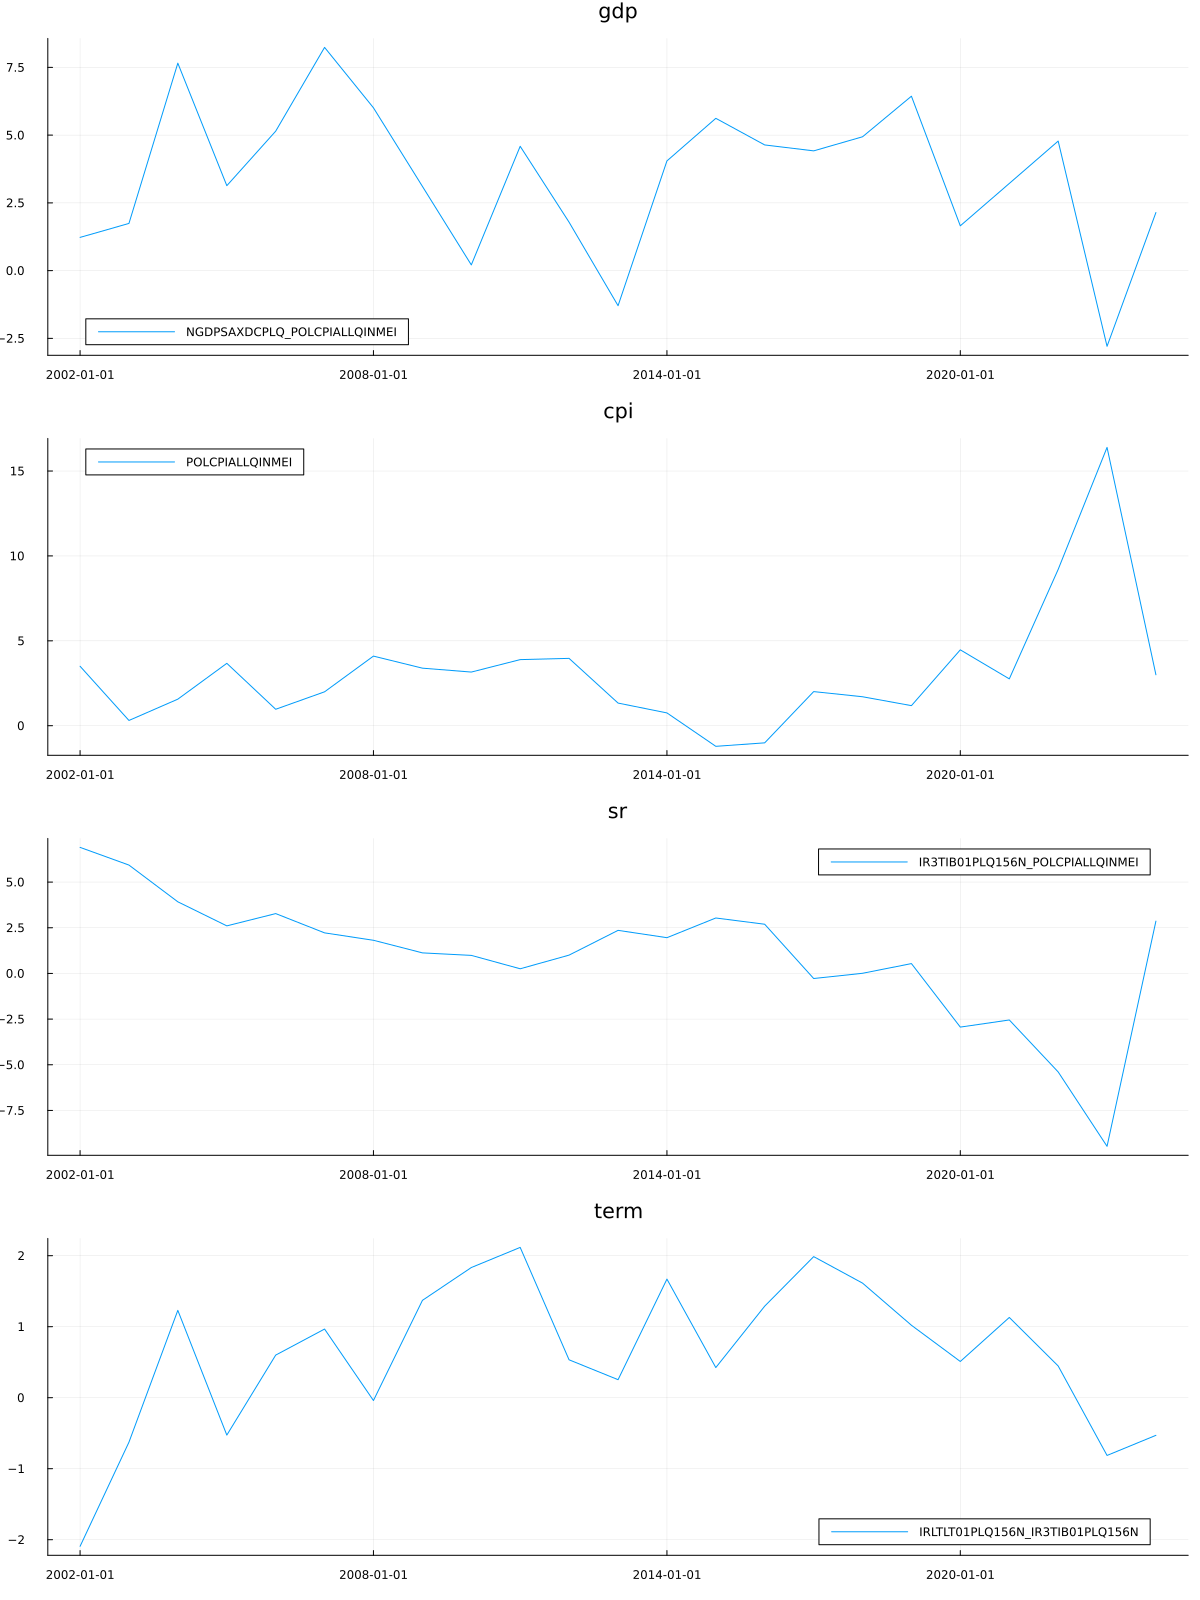

In [22]:
plot(s_data; layout = (4,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term"])

In [23]:
assets_names = colnames(s_data)
T, n_assets = size(s_data)
model = VARModel(s_data)
model_summary(model)

,const,NGDPSAXDCPLQ_POLCPIALLQINMEI,POLCPIALLQINMEI,IR3TIB01PLQ156N_POLCPIALLQINMEI,IRLTLT01PLQ156N_IR3TIB01PLQ156N,std
NGDPSAXDCPLQ_POLCPIALLQINMEI,6.0475,-0.1281,-0.5352,-0.1222,-0.3134,2.4955
POLCPIALLQINMEI,1.1147,0.5786,0.1792,-0.5414,-0.2505,3.0619
IR3TIB01PLQ156N_POLCPIALLQINMEI,-1.647,-0.3443,0.6815,1.207,0.583,2.3076
IRLTLT01PLQ156N_IR3TIB01PLQ156N,1.8935,-0.1855,-0.2,-0.0491,0.2663,0.6311


,NGDPSAXDCPLQ_POLCPIALLQINMEI,POLCPIALLQINMEI,IR3TIB01PLQ156N_POLCPIALLQINMEI,IRLTLT01PLQ156N_IR3TIB01PLQ156N
NGDPSAXDCPLQ_POLCPIALLQINMEI,1.0,-0.37,0.51,0.16
POLCPIALLQINMEI,-0.37,1.0,-0.94,-0.16
IR3TIB01PLQ156N_POLCPIALLQINMEI,0.51,-0.94,1.0,0.07
IRLTLT01PLQ156N_IR3TIB01PLQ156N,0.16,-0.16,0.07,1.0


In [24]:
#unconditional mean
c = model.C[1,:]
Β = model.C[2:end,:]

uμ = inv(I(4) - Β) * c

4-element Vector{Float64}:
  4.4473209140999215
 -6.27043424046628
 -6.347391488250766
 -2.222029087720188

In [25]:
scenarios = simulate(model, 25*freq, 10_000)
#periods = [2,6, 16, 26]
periods = [1,5, 15, 25]
ret_in_years = cum_returns_in_periods(scenarios, periods, freq, true)
print_scenarios_summary(ret_in_years, assets_names, string.(periods))

for a in 1:n_assets
    print_scenarios_percentiles(ret_in_years[a, :, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), string.(assets_names[a]))
end  

,NGDPSAXDCPLQ_POLCPIALLQINMEI,POLCPIALLQINMEI,IR3TIB01PLQ156N_POLCPIALLQINMEI,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,14.2398,9.2472,8.3018,1.8151
5,14.004,12.974,2.1362,2.7519
15,13.9675,13.6575,1.0202,2.8829
25,13.9517,13.818,0.801,2.9024


,NGDPSAXDCPLQ_POLCPIALLQINMEI,POLCPIALLQINMEI,IR3TIB01PLQ156N_POLCPIALLQINMEI,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,4.8268,6.8638,4.5483,1.6758
5,2.374,2.9368,2.9034,1.0276
15,1.397,1.652,1.7781,0.6157
25,1.0766,1.2752,1.3989,0.4801


,NGDPSAXDCPLQ_POLCPIALLQINMEI,POLCPIALLQINMEI,IR3TIB01PLQ156N_POLCPIALLQINMEI,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,0.0231,0.0331,-0.0113,-0.008
5,-0.0221,-0.002,0.0297,0.0006
15,0.033,-0.014,0.0373,0.0065
25,0.039,-0.0385,0.0206,0.0075


,NGDPSAXDCPLQ_POLCPIALLQINMEI,POLCPIALLQINMEI,IR3TIB01PLQ156N_POLCPIALLQINMEI,IRLTLT01PLQ156N_IR3TIB01PLQ156N
1,0.0007,-0.0386,-0.0228,0.0159
5,-0.0816,-0.0486,-0.0015,-0.0376
15,0.0703,0.091,0.0721,0.0264
25,0.1094,0.0375,0.016,-0.0268


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,3.1824,4.9233,6.3444,10.9397,14.2563,17.4755,22.1758,23.6062,25.5384
5,8.5088,9.3316,10.0868,12.38,14.0139,15.6001,17.8642,18.5651,19.3629
15,10.8043,11.2315,11.7017,13.0172,13.9425,14.9082,16.2699,16.7588,17.2515
25,11.4583,11.8573,12.1932,13.2316,13.9381,14.6704,15.7258,16.1093,16.5115


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-6.3393,-4.1472,-2.0331,4.6523,9.1886,13.8744,20.7045,22.6858,25.2525
5,6.1594,7.2092,8.1167,11.0111,12.9834,14.9402,17.8397,18.742,19.882
15,9.7572,10.3851,10.9586,12.5608,13.6474,14.7736,16.366,16.8897,17.5505
25,10.82,11.2784,11.6998,12.9689,13.8354,14.6632,15.9005,16.2974,16.7937


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-2.3234,-0.7271,0.7981,5.2218,8.3437,11.3942,15.7559,17.3275,18.9072
5,-4.6479,-3.5269,-2.5617,0.1452,2.1277,4.1054,6.9386,7.893,8.9474
15,-3.1341,-2.4169,-1.8477,-0.1686,1.0021,2.2223,3.9605,4.5075,5.2717
25,-2.4269,-1.9353,-1.5046,-0.1429,0.8027,1.7508,3.0871,3.5456,4.0766


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-2.1119,-1.5097,-0.9532,0.6848,1.8277,2.9325,4.5932,5.094,5.7174
5,0.3674,0.7243,1.0719,2.0503,2.7504,3.4471,4.451,4.7725,5.1003
15,1.4484,1.6823,1.883,2.4709,2.8788,3.2923,3.9014,4.0993,4.3036
25,1.7829,1.9604,2.1093,2.5802,2.8985,3.2315,3.6851,3.8339,4.0153


In [26]:
sr = scenarios[2, :,:] + scenarios[3, :,:] 
lr = scenarios[2, :,:] + scenarios[3, :,:] + scenarios[4, :,:] 
#= real_Δd = scenarios[2, :,:] + scenarios[5, :,:]
dy = exp.(scenarios[6, :,:]) =#



print_scenarios_percentiles(sr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "sr")
print_scenarios_percentiles(lr[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "lr")
#= print_scenarios_percentiles(cumsum(real_Δd, dims=1)[periods,:] ./ (periods.-1), [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "Δd")
print_scenarios_percentiles(dy[periods, :], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.(periods), "dy") =#



,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633,5.8633
5,-0.867,-0.1009,0.4617,2.3081,3.617,4.9361,6.8114,7.4134,8.1998
15,-0.8114,-0.1076,0.4464,2.3264,3.6402,4.9342,6.8086,7.4106,8.147
25,-0.859,-0.1704,0.3917,2.3084,3.6209,4.9618,6.7543,7.3057,8.034


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333,5.3333
5,0.7986,1.4138,1.9108,3.3918,4.433,5.4519,7.0316,7.4951,8.0506
15,0.8169,1.317,1.8024,3.3007,4.3641,5.4239,6.942,7.3932,8.0288
25,0.6637,1.2935,1.7861,3.3001,4.3584,5.4119,6.9184,7.4222,7.9252


In [27]:
bond_returns = calculate_bond_returns(lr./100, 10, 1)
bond_cum_returns = cumsum(bond_returns, dims=1)[periods,:] ./ periods

real_bond_returns = bond_returns .- (scenarios[2, 2:end, :] ./100)
real_bond_cum_returns = cumsum(real_bond_returns, dims=1)[periods,:] ./ periods

print_scenarios_percentiles(bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "bonds returns")
print_scenarios_percentiles(real_bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "real bonds returns")


mdd, mddl = max_drawdown_and_length(real_bond_returns)

display("real bonds")
display("mdd")
display(quantile(mdd, [.05, .25, .5, .75, .95])')
display("mddl")
display(quantile(mddl, [.05, .25, .5, .75, .95])')


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.0913,-0.0637,-0.0431,0.0274,0.0843,0.1459,0.236,0.2685,0.3087
5,0.0198,0.0269,0.0324,0.0504,0.0637,0.0781,0.1004,0.108,0.1177
10,0.0317,0.0349,0.0379,0.0462,0.0524,0.0587,0.0678,0.0711,0.0746
25,0.0345,0.0368,0.039,0.0455,0.05,0.0546,0.0614,0.0636,0.0664


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-0.1606,-0.1256,-0.0947,-0.0025,0.07,0.1462,0.256,0.296,0.3472
5,-0.0328,-0.0213,-0.0117,0.0173,0.0386,0.06,0.0935,0.1052,0.1175
10,-0.0097,-0.0046,-0.0003,0.0116,0.0205,0.0294,0.0425,0.0472,0.0523
25,-0.0045,-0.0008,0.0018,0.0106,0.0168,0.0233,0.0323,0.0355,0.0386


"real bonds"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.365117  0.422387  0.466489  0.51169  0.582123

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 16.0  21.0  28.0  36.0  54.0

In [28]:
B = collect(model.C[2:end,:]')

resp = girf(B, model.Σ, 10, 2, 1)



11×4 Matrix{Float64}:
 -0.913348     3.06186     -2.17684     -0.098582
 -1.22484      1.22354     -0.283831    -0.362182
 -0.349741    -0.245024     0.701793    -0.0999873
  0.121527    -0.601187     0.742187     0.0527649
  0.198964    -0.452473     0.475024     0.0752667
  0.135044    -0.242007     0.240367     0.0502823
  0.0670931   -0.107968     0.108013     0.0249266
  0.028179    -0.0452525    0.0482226    0.0104768
  0.0114334   -0.0205381    0.0237706    0.00424312
  0.00529296  -0.0109979    0.0132313    0.00194836
  0.00298065  -0.00656011   0.00778851   0.00108628

In [29]:
resp[2,2] + resp[2,3]  + resp[2,4]

0.5775287562066393

gdp + 
- sr .42
- lr .25

gdp -
- sr - .42
- lr - .25

cpi +
- sr .09
- lr .2


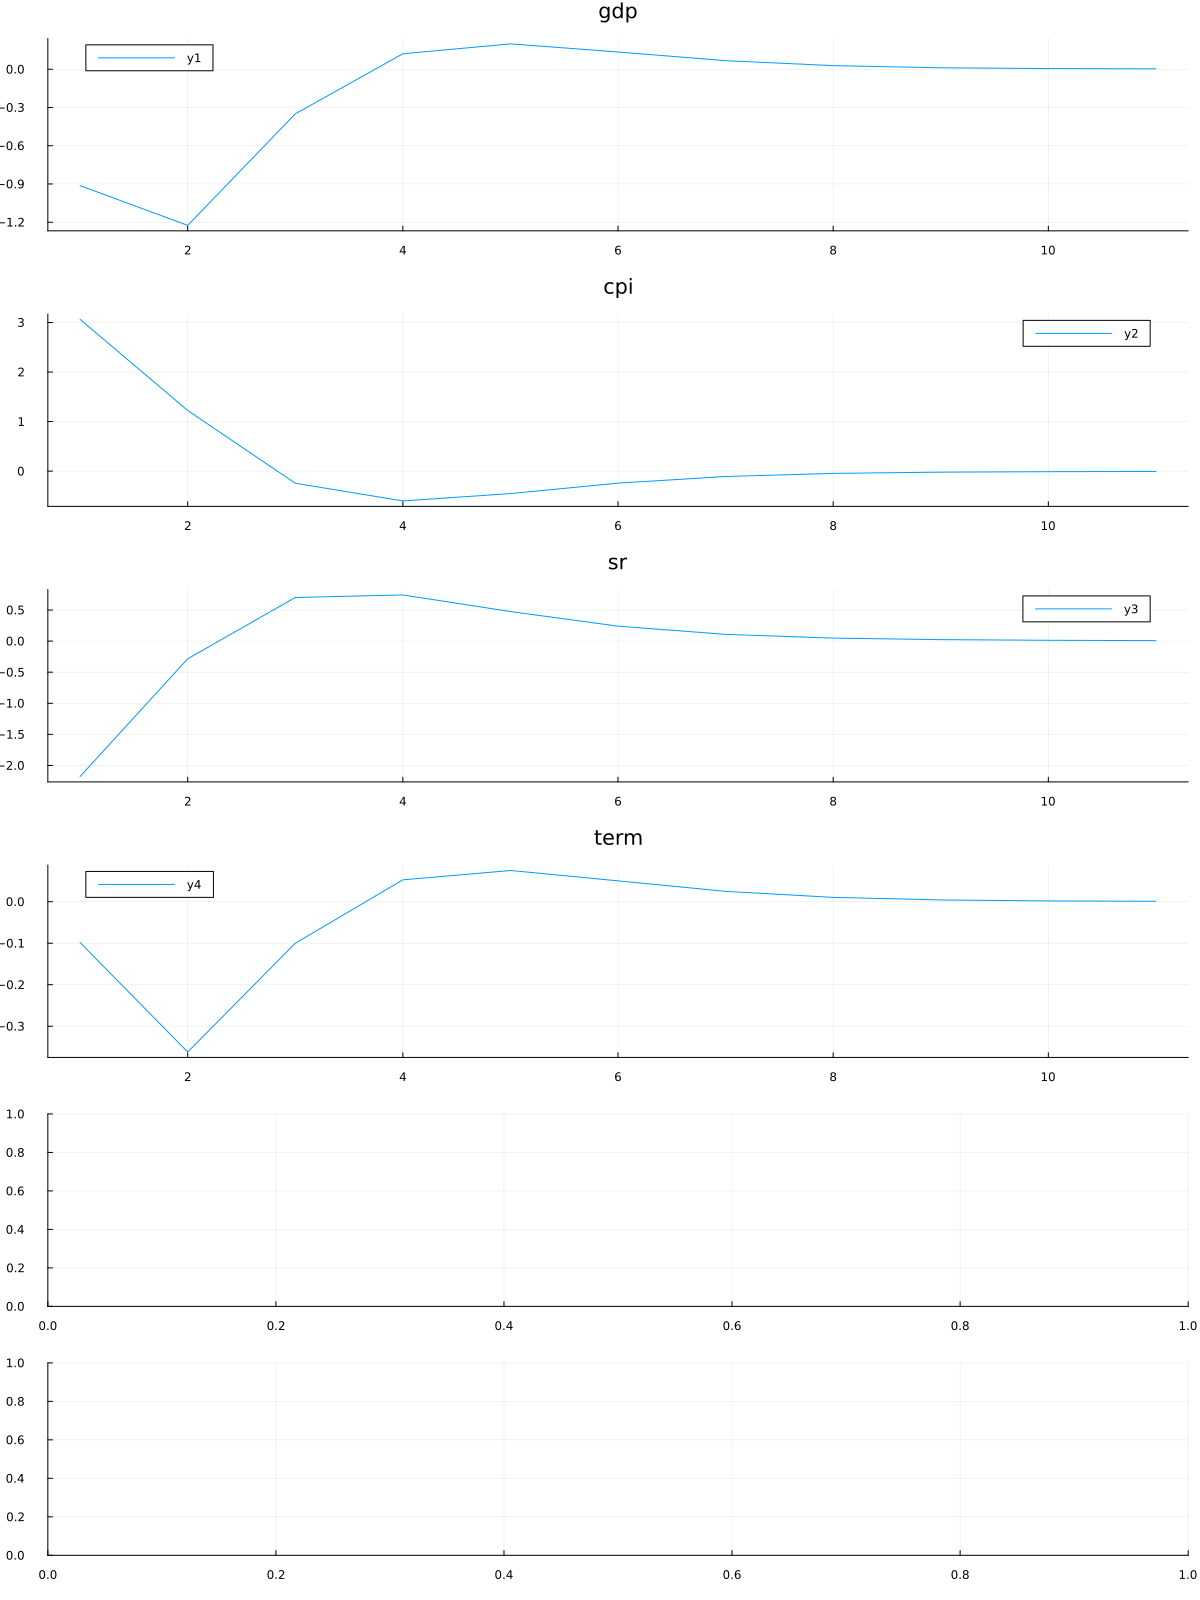

In [30]:
plot(resp; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

IRF returns
- estimate dy, and div idnex, based on initial value, mean?
- estimate returns?
- 

In [31]:
resp

11×4 Matrix{Float64}:
 -0.913348     3.06186     -2.17684     -0.098582
 -1.22484      1.22354     -0.283831    -0.362182
 -0.349741    -0.245024     0.701793    -0.0999873
  0.121527    -0.601187     0.742187     0.0527649
  0.198964    -0.452473     0.475024     0.0752667
  0.135044    -0.242007     0.240367     0.0502823
  0.0670931   -0.107968     0.108013     0.0249266
  0.028179    -0.0452525    0.0482226    0.0104768
  0.0114334   -0.0205381    0.0237706    0.00424312
  0.00529296  -0.0109979    0.0132313    0.00194836
  0.00298065  -0.00656011   0.00778851   0.00108628